# DATA PLOTS

In [2]:
# Loads data from both tables

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from database import run_all_query

# Define valid trading dates (weekdays only)
valid_dates = [
    '2024-07-29', '2024-07-30', '2024-07-31', '2024-08-01', '2024-08-02',
    '2024-08-05', '2024-08-06', '2024-08-07', '2024-08-08', '2024-08-09',
    '2024-08-12', '2024-08-13', '2024-08-14', '2024-08-15', '2024-08-16',
    '2024-08-19', '2024-08-20', '2024-08-21', '2024-08-22', '2024-08-23',
    '2024-08-26', '2024-08-27', '2024-08-28', '2024-08-29', '2024-08-30'
]

# Convert to datetime
valid_dates = pd.to_datetime(valid_dates)

# Function to handle daily balances to plot against each other for each machine learning model
def create_balance_plot(currency_pair, starting_balance):

    # Load data from trade_results
    query_trade_results = f"""
        SELECT * FROM trade_results
        WHERE userID = 1 AND ticker = '{currency_pair}'
    """
    data_trade_results = run_all_query(query_trade_results)

    # Load data from noml_trades
    query_noml_trades = f"""
        SELECT * FROM noml_trades
        WHERE userID = 1 AND ticker = '{currency_pair}'
    """
    data_noml_trades = run_all_query(query_noml_trades)

    # Manually specify the column names based on table structure
    columns = [
        'id', 'userid', 'ticker', 'mla', 'position_type', 'quantity',
        'security_price', 'total_price', 'profit', 'balance', 'purchase_date',
        'bb_upper_band', 'bb_lower_band', 'rsi', 'adx', 'di_pos', 'di_neg',
        'volatility', 'confidence_probability'
    ]

    # Convert data to DataFrame and assign column names
    df_trade_results = pd.DataFrame(data_trade_results, columns=columns)
    df_noml_trades = pd.DataFrame(data_noml_trades, columns=columns)

    # Change the mla column in df_noml_trades from 1 to 0 to avoid conflict
    df_noml_trades['mla'] = 0

    # Combine both DataFrames
    df = pd.concat([df_trade_results, df_noml_trades])

    # Ensure purchase_date is in datetime format
    df['purchase_date'] = pd.to_datetime(df['purchase_date'])
    df['purchase_date_only'] = df['purchase_date'].dt.date

    # Create a DataFrame to store results with 'trading_day' as date reference column
    balance_results = pd.DataFrame({'trading_day': valid_dates})

    # Initialise balances for each model
    model_names = {0: 'NoML', 1: 'MLP', 2: 'SVM', 3: 'RF', 4: 'LSTM'}

    # Loop through each ml model type
    for mla_value in model_names.keys():
        balance_results[mla_value] = starting_balance

        # Filter DataFrame by MLA value
        df_mla = df[df['mla'] == mla_value]

        # Incase no trades, use last known balance as current balance
        last_balance = starting_balance

        # Loop through each trading day in the range
        for date in valid_dates:
            # Filter trades for the current date
            daily_trades = df_mla[df_mla['purchase_date_only'] == date.date()]

            if not daily_trades.empty:
                # Update balance with the last entry of the day
                last_balance = daily_trades['balance'].iloc[-1]

            # Assign the balance for the current date
            balance_results.loc[balance_results['trading_day'] == date, mla_value] = last_balance

    # Convert 'trading_day' to string for categorical x-axis
    balance_results['trading_day_str'] = balance_results['trading_day'].dt.strftime('%m-%d')

    # Plotting
    plt.figure(figsize=(14, 8))

    # Plot each model's balance
    for mla_value in balance_results.columns[1:-1]:  # Skip the 'trading_day' column and 'trading_day_str'
        plt.plot(balance_results['trading_day_str'], balance_results[mla_value], label=model_names[mla_value])

    # Set x-axis to be categorical based on 'trading_day_str'
    plt.xticks()

    # Adjust x-axis limits to cover only the trading days and remove extra space
    plt.xlim([balance_results['trading_day_str'].iloc[0], balance_results['trading_day_str'].iloc[-1]])

    # Handle the plot labels
    plt.xlabel('Trading Day (2024)')
    plt.ylabel('Balance (£)')
    plt.title(f'Balance By Day {currency_pair}')
    plt.legend(title='Model Type')
    plt.grid(True)
    plt.tight_layout()  # Adjust layout to ensure everything fits
    plt.show()

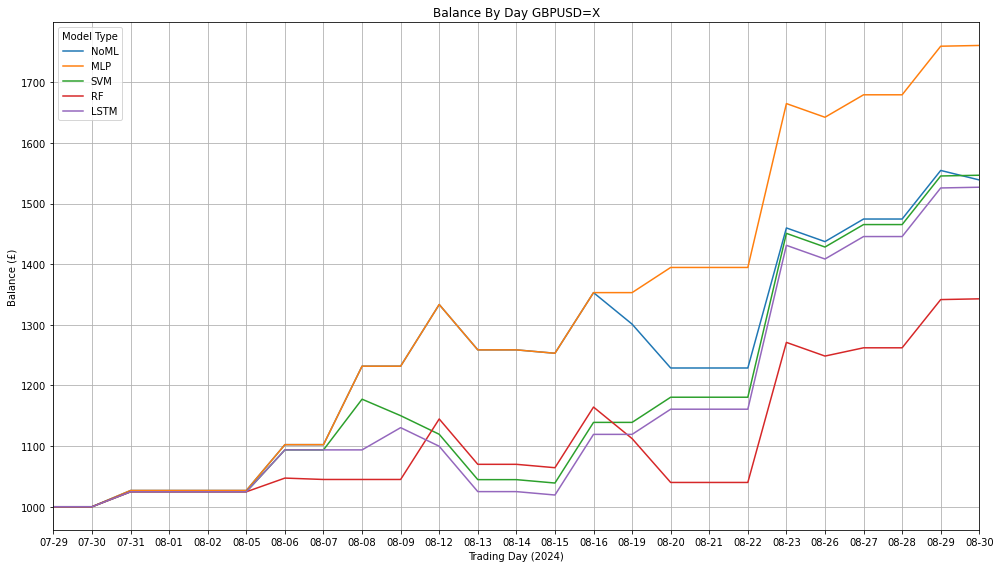

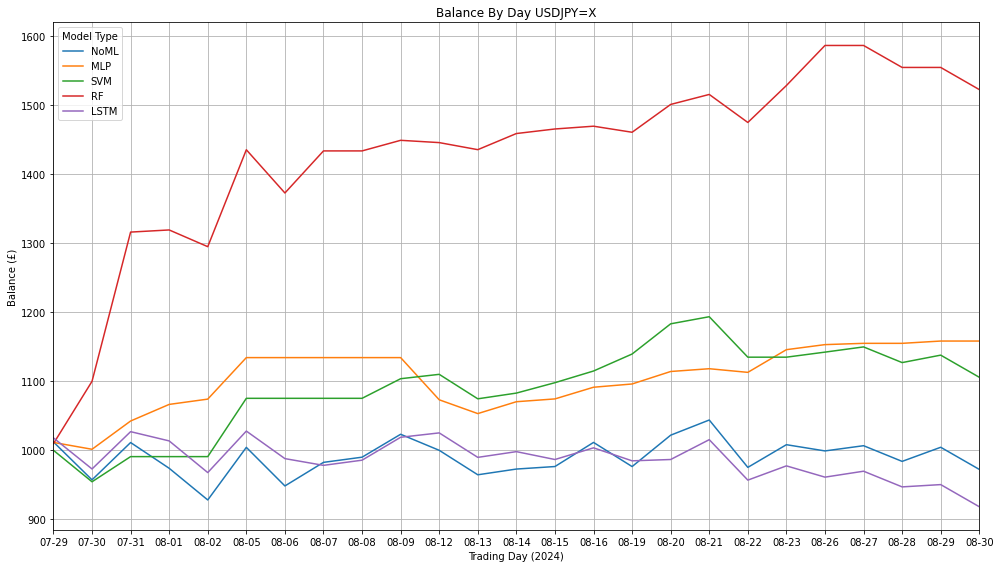

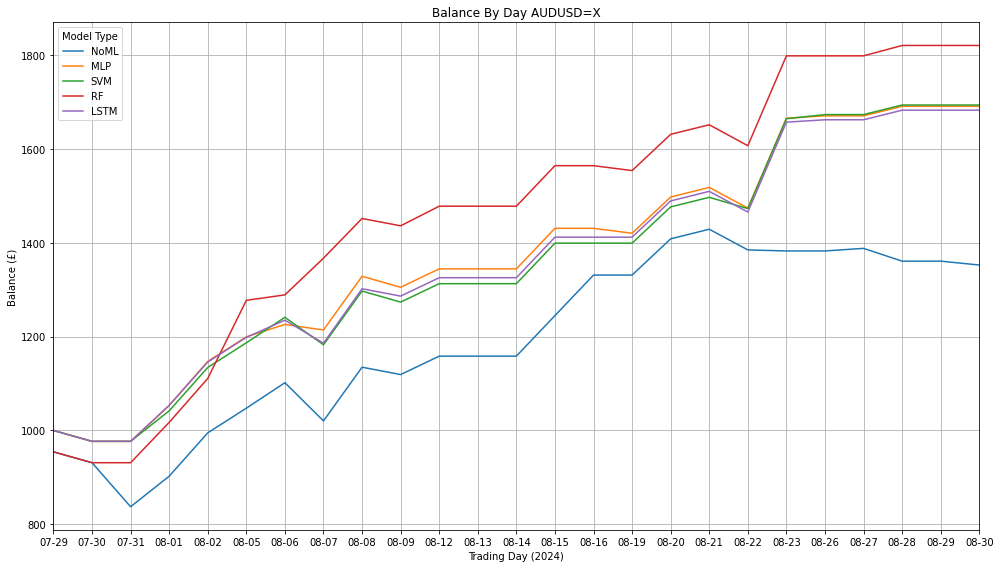

In [3]:
# Make Plots

# Define the currency pair you want to analyse
starting_balance = 1000

GBPUSD = 'GBPUSD=X'
JPYUSD = 'USDJPY=X'
AUDUSD = 'AUDUSD=X'

create_balance_plot(GBPUSD, starting_balance)
create_balance_plot(JPYUSD, starting_balance)
create_balance_plot(AUDUSD, starting_balance)

In [4]:
# Get Number of Trades Data

# SQL Query
query_trade_counts = """
    (SELECT
        ticker AS currency_pair,
        mla,
        COUNT(*) AS trade_count
    FROM
        trade_results
    WHERE
        position_type IN (0, -2)
    GROUP BY
        ticker, mla)

    UNION ALL

    (SELECT
        ticker AS currency_pair,
        0 AS mla,
        COUNT(*) AS trade_count
    FROM
        noml_trades
    WHERE
        position_type IN (0, -2)
    GROUP BY
        ticker)
"""

# Call to database handler function
trade_counts = run_all_query(query_trade_counts)

# Manually specify the column names 
columns = ['currency_pair', 'mla', 'trade_count']

# Convert the result to a DataFrame
trade_counts_df = pd.DataFrame(trade_counts, columns=columns)

display(trade_counts_df)

,currency_pair,mla,trade_count
0,GBPUSD=X,1,21
1,USDJPY=X,1,43
2,AUDUSD=X,1,37
3,GBPUSD=X,2,25
4,USDJPY=X,2,52
5,AUDUSD=X,2,38
6,GBPUSD=X,3,25
7,USDJPY=X,3,68
8,AUDUSD=X,3,32
9,GBPUSD=X,4,22


In [5]:
# Get average loss/gain, max loss/gain from SQL database

# Create query
query_max_gain_loss = """
    (SELECT
        ticker AS currency_pair,
        mla,
        MAX(CASE WHEN profit > 0 THEN profit ELSE NULL END) AS max_gain,
        MIN(CASE WHEN profit < 0 THEN profit ELSE NULL END) AS max_loss
    FROM
        trade_results
    WHERE
        position_type IN (0, -2)
    GROUP BY
        ticker, mla)

    UNION ALL

    (SELECT
        ticker AS currency_pair,
        0 AS mla,
        MAX(CASE WHEN profit > 0 THEN profit ELSE NULL END) AS max_gain,
        MIN(CASE WHEN profit < 0 THEN profit ELSE NULL END) AS max_loss
    FROM
        noml_trades
    WHERE
        position_type IN (0, -2)
    GROUP BY
        ticker)
"""

query_avg_gain_loss = """
    (SELECT
        ticker AS currency_pair,
        mla,
        AVG(CASE WHEN profit >= 0 THEN profit ELSE NULL END) AS avg_gain,
        AVG(CASE WHEN profit < 0 THEN profit ELSE NULL END) AS avg_loss
    FROM
        trade_results
    WHERE
        position_type IN (0, -2)
    GROUP BY
        ticker, mla)

    UNION ALL

    (SELECT
        ticker AS currency_pair,
        0 AS mla,
        AVG(CASE WHEN profit >= 0 THEN profit ELSE NULL END) AS avg_gain,
        AVG(CASE WHEN profit < 0 THEN profit ELSE NULL END) AS avg_loss
    FROM
        noml_trades
    WHERE
        position_type IN (0, -2)
    GROUP BY
        ticker)
"""

# Call to database handler function
max_gain_loss_results = run_all_query(query_max_gain_loss)
avg_gain_loss_results = run_all_query(query_avg_gain_loss)

# Convert the results to DataFrames
columns_max_gain_loss = ['currency_pair', 'mla', 'max_gain', 'max_loss']
columns_avg_gain_loss = ['currency_pair', 'mla', 'avg_gain', 'avg_loss']

max_gain_loss_df = pd.DataFrame(max_gain_loss_results, columns=columns_max_gain_loss)
avg_gain_loss_df = pd.DataFrame(avg_gain_loss_results, columns=columns_avg_gain_loss)

print("Max Gain and Loss:")
display(max_gain_loss_df)

print("\nAverage Gain and Loss:")
display(avg_gain_loss_df)

Max Gain and Loss:


,currency_pair,mla,max_gain,max_loss
0,GBPUSD=X,1,270.2110,-26.3960
1,USDJPY=X,1,57.2841,-40.6940
2,AUDUSD=X,1,191.5400,-32.4139
3,GBPUSD=X,2,270.2110,-26.3960
4,USDJPY=X,2,57.2841,-40.2461
5,AUDUSD=X,2,191.5400,-32.4139
6,GBPUSD=X,3,230.9590,-26.6498
7,USDJPY=X,3,240.3210,-43.9004
8,AUDUSD=X,3,191.5400,-24.5470
9,GBPUSD=X,4,270.2110,-26.3960



Average Gain and Loss:


,currency_pair,mla,avg_gain,avg_loss
0,GBPUSD=X,1,70.386509,-19.298090
1,USDJPY=X,1,9.751624,-19.258499
2,AUDUSD=X,1,45.933580,-21.297794
3,GBPUSD=X,2,73.153298,-18.431651
4,USDJPY=X,2,11.579401,-15.996563
5,AUDUSD=X,2,44.566654,-22.085485
6,GBPUSD=X,3,74.433088,-20.441340
7,USDJPY=X,3,30.434066,-21.137296
8,AUDUSD=X,3,53.482750,-20.748615
9,GBPUSD=X,4,66.864199,-18.965674


In [6]:
# Get number of positive and negative trades

# Create query to get total positive, negative, and stop-loss trades
query_total_trades_with_stoploss = """
    (SELECT
        ticker AS currency_pair,
        mla,
        SUM(CASE WHEN profit > 0 THEN 1 ELSE 0 END) AS total_positive_trades,
        SUM(CASE WHEN profit < 0 THEN 1 ELSE 0 END) AS total_negative_trades,
        SUM(CASE WHEN position_type = -2 THEN 1 ELSE 0 END) AS total_stoploss_trades
    FROM
        trade_results
    WHERE
        position_type IN (0, -2)
    GROUP BY
        ticker, mla)

    UNION ALL

    (SELECT
        ticker AS currency_pair,
        0 AS mla,
        SUM(CASE WHEN profit > 0 THEN 1 ELSE 0 END) AS total_positive_trades,
        SUM(CASE WHEN profit < 0 THEN 1 ELSE 0 END) AS total_negative_trades,
        SUM(CASE WHEN position_type = -2 THEN 1 ELSE 0 END) AS total_stoploss_trades
    FROM
        noml_trades
    WHERE
        position_type IN (0, -2)
    GROUP BY
        ticker)
"""

# Call to database handler function
total_trades_with_stoploss_results = run_all_query(query_total_trades_with_stoploss)

# Convert the result to a DataFrame
columns_total_trades_with_stoploss = [
    'currency_pair', 'mla', 'total_positive_trades', 'total_negative_trades', 'total_stoploss_trades'
]
total_trades_with_stoploss_df = pd.DataFrame(total_trades_with_stoploss_results, columns=columns_total_trades_with_stoploss)

display(total_trades_with_stoploss_df)

,currency_pair,mla,total_positive_trades,total_negative_trades,total_stoploss_trades
0,GBPUSD=X,1,13,8,6
1,USDJPY=X,1,34,9,5
2,AUDUSD=X,1,22,15,12
3,GBPUSD=X,2,11,14,10
4,USDJPY=X,2,34,18,12
5,AUDUSD=X,2,23,15,13
6,GBPUSD=X,3,9,16,13
7,USDJPY=X,3,38,30,26
8,AUDUSD=X,3,20,12,10
9,GBPUSD=X,4,11,11,8


In [7]:
# Get metrics for confidence proabilities during trades

# Create query to get confidence probability statistics
query_confidence_stats = """
    SELECT
        ticker AS currency_pair,
        mla AS model,
        MAX(confidence_probability) AS max_confidence_probability,
        MIN(confidence_probability) AS min_confidence_probability,
        AVG(confidence_probability) AS avg_confidence_probability
    FROM
        trade_results
    WHERE
        mla IN (1, 2, 3, 4) AND position_type IN (1, -1)
    GROUP BY
        ticker, mla
"""

# Call to database handler function
confidence_stats_results = run_all_query(query_confidence_stats)

# Convert the result to a DataFrame
columns_confidence_stats = [
    'currency_pair', 'model', 'max_confidence_probability', 'min_confidence_probability', 'avg_confidence_probability'
]
confidence_stats_df = pd.DataFrame(confidence_stats_results, columns=columns_confidence_stats)

display(confidence_stats_df)


,currency_pair,model,max_confidence_probability,min_confidence_probability,avg_confidence_probability
0,GBPUSD=X,1,0.805995,0.516829,0.657554
1,USDJPY=X,1,0.845419,0.535826,0.621196
2,AUDUSD=X,1,0.996417,0.502661,0.689725
3,GBPUSD=X,2,0.628070,0.526729,0.565379
4,USDJPY=X,2,0.644748,0.505095,0.562515
5,AUDUSD=X,2,0.766682,0.505119,0.578668
6,GBPUSD=X,3,1.000000,0.508781,0.867772
7,USDJPY=X,3,0.977894,0.516874,0.753642
8,AUDUSD=X,3,0.922691,0.513414,0.762675
9,GBPUSD=X,4,0.735102,0.537510,0.619440


In [121]:
# Get metrics for machine learning algorithms

# Create query to get performance metrics statistics for models 1 to 4
query_performance_stats = """
    SELECT
        ticker AS currency_pair,
        ml_model AS mla,
        MAX(accuracy) AS max_accuracy,
        MIN(accuracy) AS min_accuracy,
        AVG(accuracy) AS avg_accuracy,
        MAX(ROC_AUC) AS max_ROC_AUC,
        MIN(ROC_AUC) AS min_ROC_AUC,
        AVG(ROC_AUC) AS avg_ROC_AUC,
        MAX(sig_accuracy) AS max_sig_accuracy,
        MIN(sig_accuracy) AS min_sig_accuracy,
        AVG(sig_accuracy) AS avg_sig_accuracy,
        MAX(sig_ROC_AUC) AS max_sig_ROC_AUC,
        MIN(sig_ROC_AUC) AS min_sig_ROC_AUC,
        AVG(sig_ROC_AUC) AS avg_sig_ROC_AUC
    FROM
        ml_results
    WHERE
        ml_model IN (1, 2, 3, 4)
    GROUP BY
        ticker, ml_model
"""

# Execute the query
performance_stats_results = run_all_query(query_performance_stats)

# Convert the result to a DataFrame
columns_performance_stats = [
    'currency_pair', 'mla', 'max_accuracy', 'min_accuracy', 'avg_accuracy',
    'max_ROC_AUC', 'min_ROC_AUC', 'avg_ROC_AUC',
    'max_sig_accuracy', 'min_sig_accuracy', 'avg_sig_accuracy',
    'max_sig_ROC_AUC', 'min_sig_ROC_AUC', 'avg_sig_ROC_AUC'
]
performance_stats_df = pd.DataFrame(performance_stats_results, columns=columns_performance_stats)

display(performance_stats_df)


,currency_pair,mla,max_accuracy,min_accuracy,avg_accuracy,max_ROC_AUC,min_ROC_AUC,avg_ROC_AUC,max_sig_accuracy,min_sig_accuracy,avg_sig_accuracy,max_sig_ROC_AUC,min_sig_ROC_AUC,avg_sig_ROC_AUC
0,GBPUSD=X,1,0.616104,0.372394,0.495425,0.596054,0.415023,0.512384,0.711027,0.411017,0.504399,0.734454,0.308955,0.526587
1,USDJPY=X,1,0.572246,0.414878,0.495003,0.721255,0.413530,0.504411,0.621469,0.395270,0.509774,0.720948,0.366442,0.515046
2,AUDUSD=X,1,0.636298,0.396254,0.526490,0.593710,0.416208,0.517015,0.696078,0.386364,0.519675,0.645609,0.387468,0.535820
3,GBPUSD=X,2,0.718907,0.390209,0.526586,0.592909,0.464738,0.526452,0.693122,0.401015,0.525560,0.735516,0.380982,0.575645
4,USDJPY=X,2,0.573981,0.433476,0.497888,0.593682,0.418154,0.507297,0.717514,0.363971,0.501860,0.741923,0.378704,0.528346
5,AUDUSD=X,2,0.657990,0.422414,0.518638,0.631331,0.409229,0.536708,0.681818,0.355932,0.503339,0.764075,0.446844,0.600321
6,GBPUSD=X,3,0.603597,0.317757,0.496004,0.643430,0.414066,0.549838,0.680608,0.304233,0.495993,0.749631,0.341583,0.561089
7,USDJPY=X,3,0.587268,0.413448,0.497428,0.634299,0.419162,0.516830,0.598870,0.392739,0.496259,0.672486,0.309734,0.506682
8,AUDUSD=X,3,0.636364,0.327549,0.521156,0.697106,0.420104,0.554082,0.685393,0.355932,0.521455,0.788971,0.251786,0.565608
9,GBPUSD=X,4,0.701653,0.411807,0.523096,0.588039,0.396762,0.512343,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
